In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

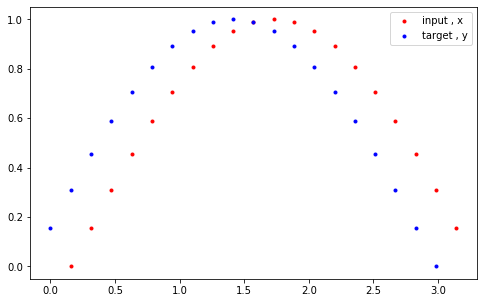

In [25]:
plt.figure(figsize= (8,5))
seq_length =20  # number of data steps/data in one batch of data
time_steps = np.linspace(0,np.pi,seq_length+1) # linespace creates a time sample values form 0 to pi of seq_len units
data =  np.sin(time_steps) # data contains the signed valued of all the time step values 

data.resize(seq_length+1,1) # adds an extra dimension to the data i.e. (21,) to (21,1)


x = data[:-1] # contains the values from 0 to 19
y = data[1:] # contains values from 1 to 20

plt.plot(time_steps[1:], x, 'r.', label = 'input , x')
plt.plot(time_steps[:-1],y, 'b.', label = 'target , y')
plt.legend(loc='best')
plt.show()

In [26]:
#Define the RNN
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self,x, hidden):
        batch_size = x.size(0)
        r_out,hidden = self.rnn(x,hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output,hidden

In [27]:
test_rnn = RNN(input_size=1, output_size=1,hidden_dim= 10, n_layers=2)

time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))


test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [28]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [29]:
criterion = nn.MSELoss() # we are using regression loss as we have to predict a value not a class
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [30]:
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.3029894232749939


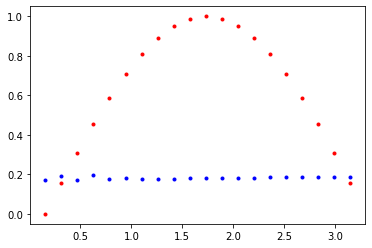

Loss:  0.01224974449723959


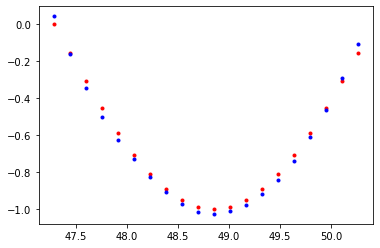

Loss:  0.04602096602320671


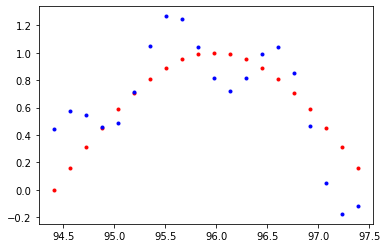

Loss:  0.008934957906603813


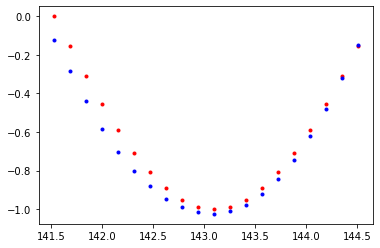

Loss:  0.0025275324005633593


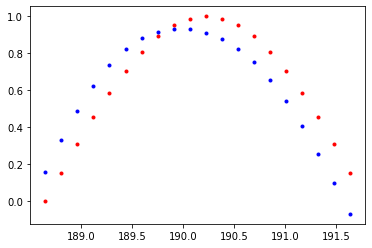

In [31]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)